In [2]:
import lightgbm as lgb
from sklearn import metrics
import category_encoders as ce

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer


import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xgboost as xgb

# Defino funciones

In [3]:
def predecir(model, train_features, train_labels, test_features, test_labels):
    predict = model.score(test_features,test_labels)
    print('Entrenamiento: {:0.4f}%'.format(model.score(train_features, train_labels)*100))
    print('Testeo: {:0.4f}%.'.format(predict*100))
    
    return predict

In [4]:
def imputar(df):
    imp = SimpleImputer()
    cols = df._get_numeric_data().columns
    df_result = df.copy()
    for x in cols:
        df_result[x]=imp.fit_transform(df[[x]])
    return df_result

In [5]:
def knn_best_distance(df,dist,x_train,y_train,x_test,y_test):
    for x in dist:
        print(x+" --------------------------")
        result , k = knn_predictor(x,x_train,y_train,x_test,y_test)
        df[x] = result
        

In [174]:
def knn_predictor(distancia,x_train,y_train,x_test,y_test):
    kesimos = []
    result = []
    for k in range(10,40):
        kesimos.append(k)
        knn = KNeighborsRegressor(n_neighbors = k, metric=distancia)
        knn.fit(x_train, y_train)
        res = predecir(knn,x_train,y_train,x_test,y_test)
        result.append(res)
    return result, kesimos

# Completo el data set

In [167]:
df = pd.read_csv('../data/train.csv',dtype={'tipodepropiedad':'category','ciudad':'category','provincia':'category'})

df['fecha'] = pd.to_datetime(df['fecha'])
df['anio'] = df['fecha'].dt.year
df["mes"] = df['fecha'].dt.month
df["dia"] = df['fecha'].dt.day

df = df.drop(columns=["lat","lng","direccion","fecha","descripcion","titulo","idzona", 'gimnasio', 
                      'usosmultiples', 'piscina', 'escuelascercanas','garages',
                      'centroscomercialescercanos', 'dia'])

In [168]:
df1 = imputar(df)
imp = SimpleImputer(strategy="constant",fill_value="-")

df1["m2"]=(df1["metroscubiertos"]+df1["metrostotales"])

df_ids = df1["id"]
df1.drop(columns=["id"])

df1["tipodepropiedad"] = imp.fit_transform(df1[["tipodepropiedad"]])
df1["provincia"] = imp.fit_transform(df1[["provincia"]])
df1["ciudad"] = imp.fit_transform(df1[["ciudad"]])



In [169]:
from sklearn.preprocessing import LabelEncoder

cat_features = ['ciudad', 'provincia', 'tipodepropiedad']

data_cols = df1._get_numeric_data().columns

baseline_data = df1[data_cols]

encoder = ce.CatBoostEncoder(cols=cat_features)
encoder.fit(df1[cat_features], df1['m2'])
encoded = encoder.transform(df1[cat_features]).transform(lambda x: x/100)
data = baseline_data.join(encoded)

In [170]:
x = data[data.columns.drop("precio")]
y = data['precio']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

print(f"Original shapes: X={x.shape} y={y.shape}")
print(f"Train shapes: X={x_train.shape} y={y_train.shape}")
print(f"Test  shapes: X={x_test.shape}  y={y_test.shape}")

Original shapes: X=(240000, 12) y=(240000,)
Train shapes: X=(192000, 12) y=(192000,)
Test  shapes: X=(48000, 12)  y=(48000,)


In [171]:
data

,id,antiguedad,habitaciones,banos,metroscubiertos,metrostotales,precio,anio,mes,m2,ciudad,provincia,tipodepropiedad
0,254099.0,8.116114,2.0,2.0,80.0,80.000000,2273000.0,2015.0,8.0,160.000000,2.816296,3.241911,2.645088
1,53461.0,10.000000,3.0,2.0,268.0,180.000000,3600000.0,2013.0,6.0,448.000000,4.424129,3.241911,3.577887
2,247984.0,5.000000,3.0,2.0,144.0,166.000000,1200000.0,2015.0,10.0,310.000000,2.226787,3.375483,3.760493
3,209067.0,1.000000,2.0,1.0,63.0,67.000000,650000.0,2012.0,3.0,130.000000,3.361077,3.534803,3.760493
4,185997.0,10.000000,2.0,1.0,95.0,95.000000,1150000.0,2016.0,6.0,190.000000,3.523198,3.375483,2.645088
...,...,...,...,...,...,...,...,...,...,...,...,...,...
239995,119879.0,0.000000,2.0,1.0,67.0,176.765145,650000.0,2015.0,2.0,243.765145,3.361077,3.534803,3.760493
239996,259178.0,0.000000,3.0,3.0,200.0,250.000000,1940000.0,2014.0,7.0,450.000000,2.891295,3.534803,3.760493
239997,131932.0,20.000000,2.0,2.0,138.0,138.000000,3400000.0,2015.0,3.0,276.000000,2.816296,3.241911,2.645088
239998,146867.0,20.000000,4.0,4.0,235.0,137.000000,2890000.0,2014.0,12.0,372.000000,2.836896,3.241911,3.760493


# Pruebo

In [175]:
k = list(range(10,40))
prueba = pd.DataFrame(k,index=k,columns=["Kactual"])

In [176]:
dists = [
"euclidean",
"manhattan",
"chebyshev"]


knn_best_distance(prueba,dists,x_train,y_train,x_test,y_test)


euclidean --------------------------
Entrenamiento: 42.4108%
Testeo: 30.1608%.
Entrenamiento: 41.8200%
Testeo: 30.6319%.
Entrenamiento: 41.2653%
Testeo: 31.0843%.
Entrenamiento: 40.8036%
Testeo: 31.4683%.
Entrenamiento: 40.3683%
Testeo: 31.6886%.
Entrenamiento: 40.0043%
Testeo: 31.9528%.
Entrenamiento: 39.6431%
Testeo: 32.1103%.
Entrenamiento: 39.3403%
Testeo: 32.3389%.
Entrenamiento: 39.0602%
Testeo: 32.4486%.
Entrenamiento: 38.8211%
Testeo: 32.5469%.
Entrenamiento: 38.5704%
Testeo: 32.6228%.
Entrenamiento: 38.3599%
Testeo: 32.7682%.
Entrenamiento: 38.1575%
Testeo: 32.8602%.
Entrenamiento: 37.9778%
Testeo: 32.9263%.
Entrenamiento: 37.8046%
Testeo: 32.9699%.
Entrenamiento: 37.6352%
Testeo: 33.0324%.
Entrenamiento: 37.4877%
Testeo: 33.0413%.
Entrenamiento: 37.3358%
Testeo: 33.0667%.
Entrenamiento: 37.2099%
Testeo: 33.0962%.
Entrenamiento: 37.1028%
Testeo: 33.1065%.
Entrenamiento: 36.9972%
Testeo: 33.1487%.
Entrenamiento: 36.8728%
Testeo: 33.1527%.
Entrenamiento: 36.7582%
Testeo: 33.1727

In [177]:
prueba.drop(columns="Kactual",inplace=True)

(30, -0.1)

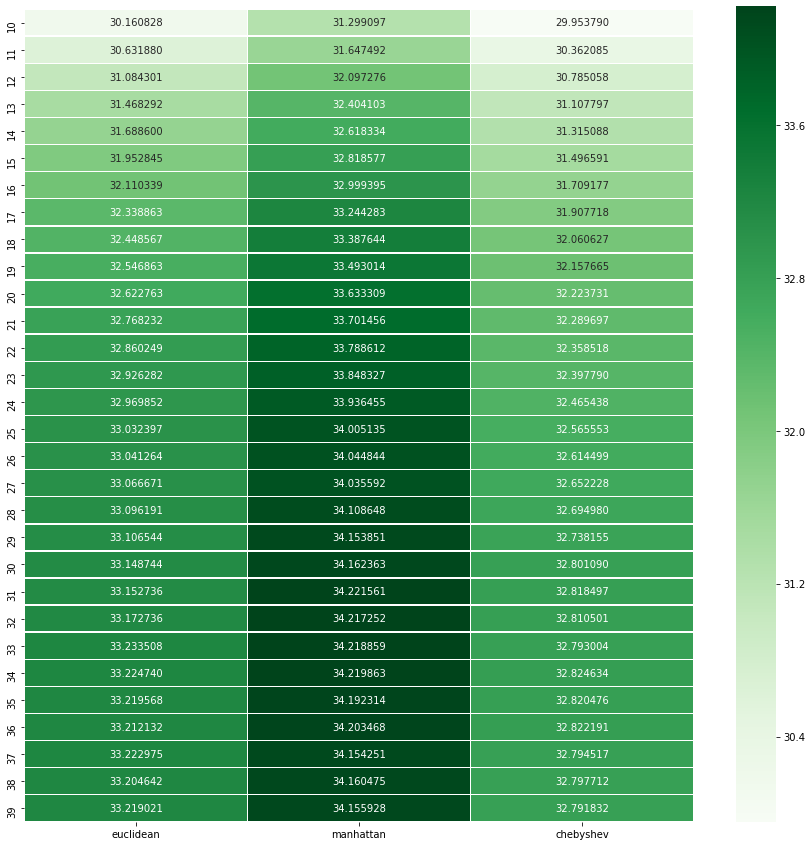

In [180]:
a= prueba.transform(lambda x: x*100)
plt.figure(figsize=(15, 15))

sns.heatmap(a, annot=True, fmt='.6f', linewidths=.5,cmap="Greens").set_ylim(30,-0.1)

In [179]:
knn = KNeighborsRegressor(n_neighbors =35, metric="manhattan")

knn.fit(x_train, y_train)

res = predecir(knn,x_train,y_train,x_test,y_test)

Entrenamiento: 37.4082%
Testeo: 34.1923%.


# Result de test

In [164]:
#Resultado de test
knn = KNeighborsRegressor(n_neighbors = 36, metric="manhattan")

#Entreno con todo el dataset
knn.fit(x, y)

#Predigo la data
predict = knn.predict(data)

In [165]:
result = df_ids.astype("int32").to_frame()
result["target"] = predict.astype("int32")

In [166]:
result = df_ids.astype("int32").to_frame()
result["target"] = predict.astype("int32")
result.to_csv("../data/results/resultKNN.csv", index=False)

In [107]:
result.head()

,id,target
0,4941,3477325
1,51775,839491
2,115253,1693631
3,299321,1240362
4,173570,930956
